# Monte Carlo Counterfactual Regret Minimization (MCCFR)

In this example we showcase how to use `cfrx` to run the MCCFR (outcome-sampling variation) on simple games Kuhn Poker, Leduc Poker.

We'll see how to:
 - Initialize an environment from `cfrx`
 - Initialize a random policy and sample a rollout
 - Write a small training loop to run the MCCFR algorithm
 - Measure the evolution of our strategy exploitability throughout the training

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from plot_utils import plot_partial


from cfrx.metrics import exploitability
from cfrx.algorithms.mccfr.outcome_sampling import MCCFRState, compute_regrets_and_strategy_profile, unroll
from cfrx.utils import regret_matching
from cfrx.policy import TabularPolicy

plt.style.use('dark_background')

In [2]:
device = jax.devices("cpu")[0]

In [3]:
# Hyperparameters
ENV_NAME = "Kuhn Poker"
NUM_ITERATIONS = 100000
EXPLORATION_FACTOR = 0.6
SEED = 0
METRICS_PERIOD = 10000

random_key = jax.random.PRNGKey(SEED)

In [4]:
if ENV_NAME  == "Kuhn Poker":
    from cfrx.envs.kuhn_poker.constants import INFO_SETS
    from cfrx.envs.kuhn_poker.env import KuhnPoker

    env_cls = KuhnPoker
    EPISODE_LEN = 8
    NUM_MAX_NODES = 100

elif ENV_NAME  == "Leduc Poker":
    from cfrx.envs.leduc_poker.constants import INFO_SETS
    from cfrx.envs.leduc_poker.env import LeducPoker
    
    env_cls = LeducPoker
    EPISODE_LEN = 20
    NUM_MAX_NODES = 2000

## The environment

[Kuhn Poker](https://en.wikipedia.org/wiki/Kuhn_poker) is a simplified version of the Poker game. In cfrx, we use the environment from [pgx](https://github.com/sotetsuk/pgx), and add a wrapper to explicitly handle random nodes and information states.

In [5]:
env = env_cls()

In [6]:
# Number of info_sets, number of possible actions
n_states = len(INFO_SETS)
n_actions = env.num_actions

n_states, n_actions

(13, 4)

In [7]:
s0 = env.init(random_key)
s0 #Cards haven't been dealed yet

State(current_player=Array(0, dtype=int8), observation=Array([False, False, False,  True, False,  True,  True], dtype=bool), rewards=Array([0., 0.], dtype=float32), terminated=Array(False, dtype=bool), truncated=Array(False, dtype=bool), legal_action_mask=Array([ True,  True,  True,  True], dtype=bool), _rng_key=Array([4146024105,  967050713], dtype=uint32), _step_count=Array(0, dtype=int32), _cards=Array([-1, -1], dtype=int8), _last_action=Array(-1, dtype=int8), _pot=Array([0, 0], dtype=int8), info_state=InfoState(private_card=Array(-1, dtype=int8), action_sequence=Array([-1, -1], dtype=int8)), chance_node=Array(True, dtype=bool), chance_prior=Array([1, 1, 1], dtype=int32))

In [8]:
# Give a J to player 1 and a K to player 2
s1 = env.step(s0, action=jnp.array(0))
s2 = env.step(s1, action=jnp.array(2))
jax.tree_map(lambda *z: jnp.stack(z), s1, s2)

State(current_player=Array([0, 0], dtype=int8), observation=Array([[ True, False, False,  True, False,  True, False],
       [ True, False, False,  True, False,  True, False]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True],
       [False,  True, False,  True]], dtype=bool), _rng_key=Array([[4146024105,  967050713],
       [4146024105,  967050713]], dtype=uint32), _step_count=Array([1, 2], dtype=int32), _cards=Array([[ 0, -1],
       [ 0,  2]], dtype=int8), _last_action=Array([-1, -1], dtype=int8), _pot=Array([[0, 0],
       [0, 0]], dtype=int8), info_state=InfoState(private_card=Array([-1,  0], dtype=int8), action_sequence=Array([[-1, -1],
       [-1, -1]], dtype=int8)), chance_node=Array([ True, False], dtype=bool), chance_prior=Array([[0, 1, 1],
       [0, 1, 0]], dtype=int32))

## Random policy

In [9]:
# Initialize a training state
training_state = MCCFRState.init(n_states, n_actions)
jax.tree_map(np.shape, training_state)

MCCFRState(regrets=(13, 4), probs=(13, 4), avg_probs=(13, 4), step=())

In [10]:
# Initialize a Policy object and print the probability distribution for our current strategy and state
policy = TabularPolicy(n_actions=n_actions,exploration_factor=EXPLORATION_FACTOR, info_state_idx_fn=env.info_state_idx)

policy.prob_distribution(
    params=training_state.probs,
    info_state=s2.info_state,
    action_mask=s2.legal_action_mask,
    use_behavior_policy=jnp.bool_(False),
)

Array([0. , 0.5, 0. , 0.5], dtype=float32)

In [11]:
# Let's do an unroll with our uniformly-random Policy
random_key, subkey = jax.random.split(random_key)
episode, states = unroll(
    init_state=s2,
    training_state=training_state,
    random_key=subkey,
    update_player=0,
    env=env,
    policy=policy,
    n_max_steps=EPISODE_LEN,
)

In [12]:
jax.tree_map(lambda x: x[~states.terminated], states)

State(current_player=Array([0, 1], dtype=int8), observation=Array([[ True, False, False,  True, False,  True, False],
       [False, False,  True,  True, False, False,  True]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[False,  True, False,  True],
       [ True, False,  True, False]], dtype=bool), _rng_key=Array([[4146024105,  967050713],
       [4146024105,  967050713]], dtype=uint32), _step_count=Array([2, 3], dtype=int32), _cards=Array([[0, 2],
       [0, 2]], dtype=int8), _last_action=Array([-1,  1], dtype=int8), _pot=Array([[0, 0],
       [1, 0]], dtype=int8), info_state=InfoState(private_card=Array([0, 2], dtype=int8), action_sequence=Array([[-1, -1],
       [ 1, -1]], dtype=int8)), chance_node=Array([False, False], dtype=bool), chance_prior=Array([[0, 1, 0],
       [0, 1, 0]], dtype=int32))

In [13]:
"".join([env_cls.action_to_string(x) for x in episode.action[episode.mask.astype(bool)]])

'bp'

## MCCFR implementation
We use the `cfrx` components to implement the MCCFR algorithm.

The algorithm consists in alternating iterations for the two players, and logging the exploitability from time to time.

Note: We make sure to Jit both the iteration and exploitability function, to make the most of Jax capabilities.

In [14]:
def do_iteration(training_state, random_key, env, policy, update_player):
    """
    Do one iteration of MCCFR: traverse the game tree once and compute counterfactual regrets and strategy profiles
    """

    random_key, subkey = jax.random.split(random_key)

    # Sample one path in the game tree
    random_key, subkey = jax.random.split(random_key)
    episode, states = unroll(
        init_state=env.init(subkey),
        training_state=training_state,
        random_key=subkey,
        update_player=update_player,
        env=env,
        policy=policy,
        n_max_steps=EPISODE_LEN,
    )

    # Compute counterfactual values and strategy profile
    (
        info_states,
        sampled_regrets,
        sampled_avg_probs,
    ) = compute_regrets_and_strategy_profile(
        episode=episode,
        training_state=training_state,
        policy=policy,
        update_player=update_player,
    )
    info_states_idx = jax.vmap(env.info_state_idx)(info_states)
    # Store regret and strategy profile values
    regrets = training_state.regrets.at[info_states_idx].add(sampled_regrets)
    avg_probs = training_state.avg_probs.at[info_states_idx].add(sampled_avg_probs)

    return regrets, avg_probs, episode


do_iteration = jax.jit(do_iteration, static_argnames=("env", "policy"), device=device)

In [15]:
# This function measures the exploitability of a strategy
exploitability_fn = jax.jit(
    lambda policy_params: exploitability(
        policy_params=policy_params,
        env=env,
        n_players=2,
        n_max_nodes=NUM_MAX_NODES,
        policy=policy,
    ),
    device=device
)

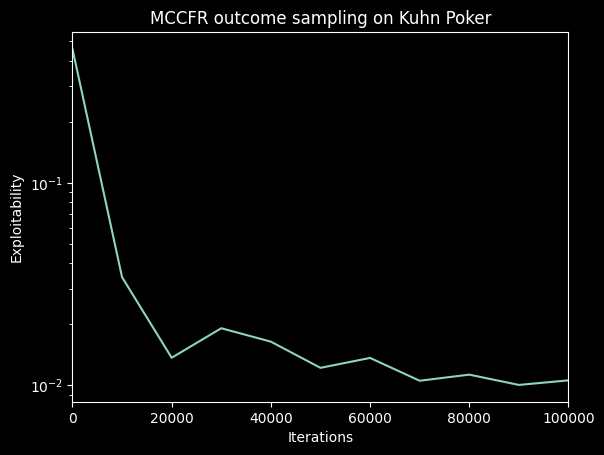

In [16]:
# One iteration consists in updating the policy for both players
n_loops = 2 * NUM_ITERATIONS

exploitabilities = []
iterations = []

for k in range(n_loops):
    random_key, subkey = jax.random.split(random_key)

    # Update players alternatively
    update_player = k % 2
    new_regrets, new_avg_probs, episode = do_iteration(
        training_state,
        random_key,
        env=env,
        policy=policy,
        update_player=update_player,
    )

    # Accumulate regrets, compute new strategy and avg strategy
    new_probs = regret_matching(new_regrets)
    new_probs /= new_probs.sum(axis=-1, keepdims=True)

    training_state = training_state._replace(
        regrets=new_regrets,
        probs=new_probs,
        avg_probs=new_avg_probs,
        step=training_state.step + 1,
    )

    # Logging

    
    if k == 0 or (k+1) % (METRICS_PERIOD*2) == 0:
        current_policy = training_state.avg_probs
        current_policy /= training_state.avg_probs.sum(axis=-1, keepdims=True)

        exp = exploitability_fn(policy_params=current_policy)

        exploitabilities.append(exp)
        iterations.append(k // 2)
        plt.xlabel("Iterations")
        plt.title(f"MCCFR outcome sampling on {ENV_NAME}")
        plt.ylabel("Exploitability")
        plt.yscale("log")
        plt.xlim(0,  NUM_ITERATIONS)

        plot_partial(plt.plot, iterations, exploitabilities)

In [17]:
exploitabilities

[Array(0.45833334, dtype=float32),
 Array(0.03423052, dtype=float32),
 Array(0.01369518, dtype=float32),
 Array(0.01915857, dtype=float32),
 Array(0.01644998, dtype=float32),
 Array(0.01221348, dtype=float32),
 Array(0.01367066, dtype=float32),
 Array(0.01054929, dtype=float32),
 Array(0.01130586, dtype=float32),
 Array(0.01005891, dtype=float32),
 Array(0.0105943, dtype=float32)]